In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), "../"))


In [2]:
import json
import time
from typing import Any

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from medbench.models import Model, ModelOutput, ModelRun
from medbench.metrics import calculate_summarization_metrics, calculate_exact_match_metrics


/home/lschettini/.pyenv/versions/3.11.11/envs/medbench-metrics-311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MEDHELM_METRICS_PATH: str = "../data/metrics/medhelm/func_output"

In [4]:
MULTIPLE_CHOICE_DATASETS = [
    "head_qa",
    "medbullet", # There's a typo in the helm data.
    "pubmed_qa",
]

In [5]:
# Map file names to model names
model_runs: dict[str, ModelRun] = {}

# Map metrics to model_runs and their values
all_metrics_data: list[dict[str, Any]] = []
for model_run_filename in os.listdir(MEDHELM_METRICS_PATH):
    metrics_data: dict
    with open(os.path.join(MEDHELM_METRICS_PATH, model_run_filename), "r") as f:
        metrics_data = json.load(f)

    model_run = ModelRun.from_json(metrics_data["original_run"]["model_run"])
    model_runs[model_run_filename] = model_run

    for metric_name, metric_val in metrics_data["metrics_results"]["aggregated_metrics"].items():
        all_metrics_data.append(
            {
                "id": model_run_filename,
                "model": model_run.model.name,
                "dataset": model_run.dataset.name,
                "metric_name": metric_name,
                "metric_value": metric_val,
            }
        )

metrics_df = pd.DataFrame(all_metrics_data)
metrics_df.head()

,id,model,dataset,metric_name,metric_value
0,"medec:model=meta_llama-3.3-70b-instruct,model_...",meta/llama-3.3-70b-instruct,medec,medec_error_flag_accuracy,0.534338
1,"medec:model=meta_llama-3.3-70b-instruct,model_...",meta/llama-3.3-70b-instruct,medec,medec_error_sentence_accuracy,0.313233
2,"medec:model=meta_llama-3.3-70b-instruct,model_...",meta/llama-3.3-70b-instruct,medec,num_references,1.000000
3,"medec:model=meta_llama-3.3-70b-instruct,model_...",meta/llama-3.3-70b-instruct,medec,num_train_trials,1.000000
4,"medec:model=meta_llama-3.3-70b-instruct,model_...",meta/llama-3.3-70b-instruct,medec,num_prompt_tokens,311.581240


In [6]:
metrics_df["metric_name"].value_counts()

metric_name
num_train_trials                 66
num_references                   66
num_prompt_tokens                66
num_completion_tokens            66
inference_runtime                66
num_output_tokens                66
prompt_truncated                 66
max_prob                         66
batch_size                       66
finish_reason_length             66
finish_reason_stop               66
finish_reason_endoftext          66
finish_reason_unknown            66
num_train_instances              66
num_bytes                        66
num_perplexity_tokens            66
logprob                          66
num_instances                    66
bits_per_byte                    55
logprob_per_byte                 55
perplexity                       55
summac                           36
bert_score                       36
rougeL                           36
summarization_density            36
summarization_compression        36
summarization_coverage           36
rouge_l         

In [7]:
medbench_metrics = [
    "bert_score",
    "rouge1",
    "rouge2",
    "rougeL",
]

metrics_df[metrics_df["metric_name"].isin(medbench_metrics)]["metric_name"].value_counts()

metric_name
bert_score    36
rouge1        36
rouge2        36
rougeL        36
Name: count, dtype: int64

In [8]:
# Filter out the metrics that are not in medbench_metrics
medhelm_metrics_df = metrics_df[metrics_df["metric_name"].isin(medbench_metrics)]

# Rename column
medhelm_metrics_df = medhelm_metrics_df.rename(columns={"metric_value": "medhelm_metric_value"})

medhelm_metrics_df.head()

,id,model,dataset,metric_name,medhelm_metric_value
77,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,bert_score,0.742938
78,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,rouge1,0.170336
79,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,rouge2,0.043668
80,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,rougeL,0.130871
112,"med_dialog,subset=healthcaremagic:model=micros...",microsoft/phi-3.5-mini-instruct,med_dialog,bert_score,0.636296


/tmp/ipykernel_1275223/535109847.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


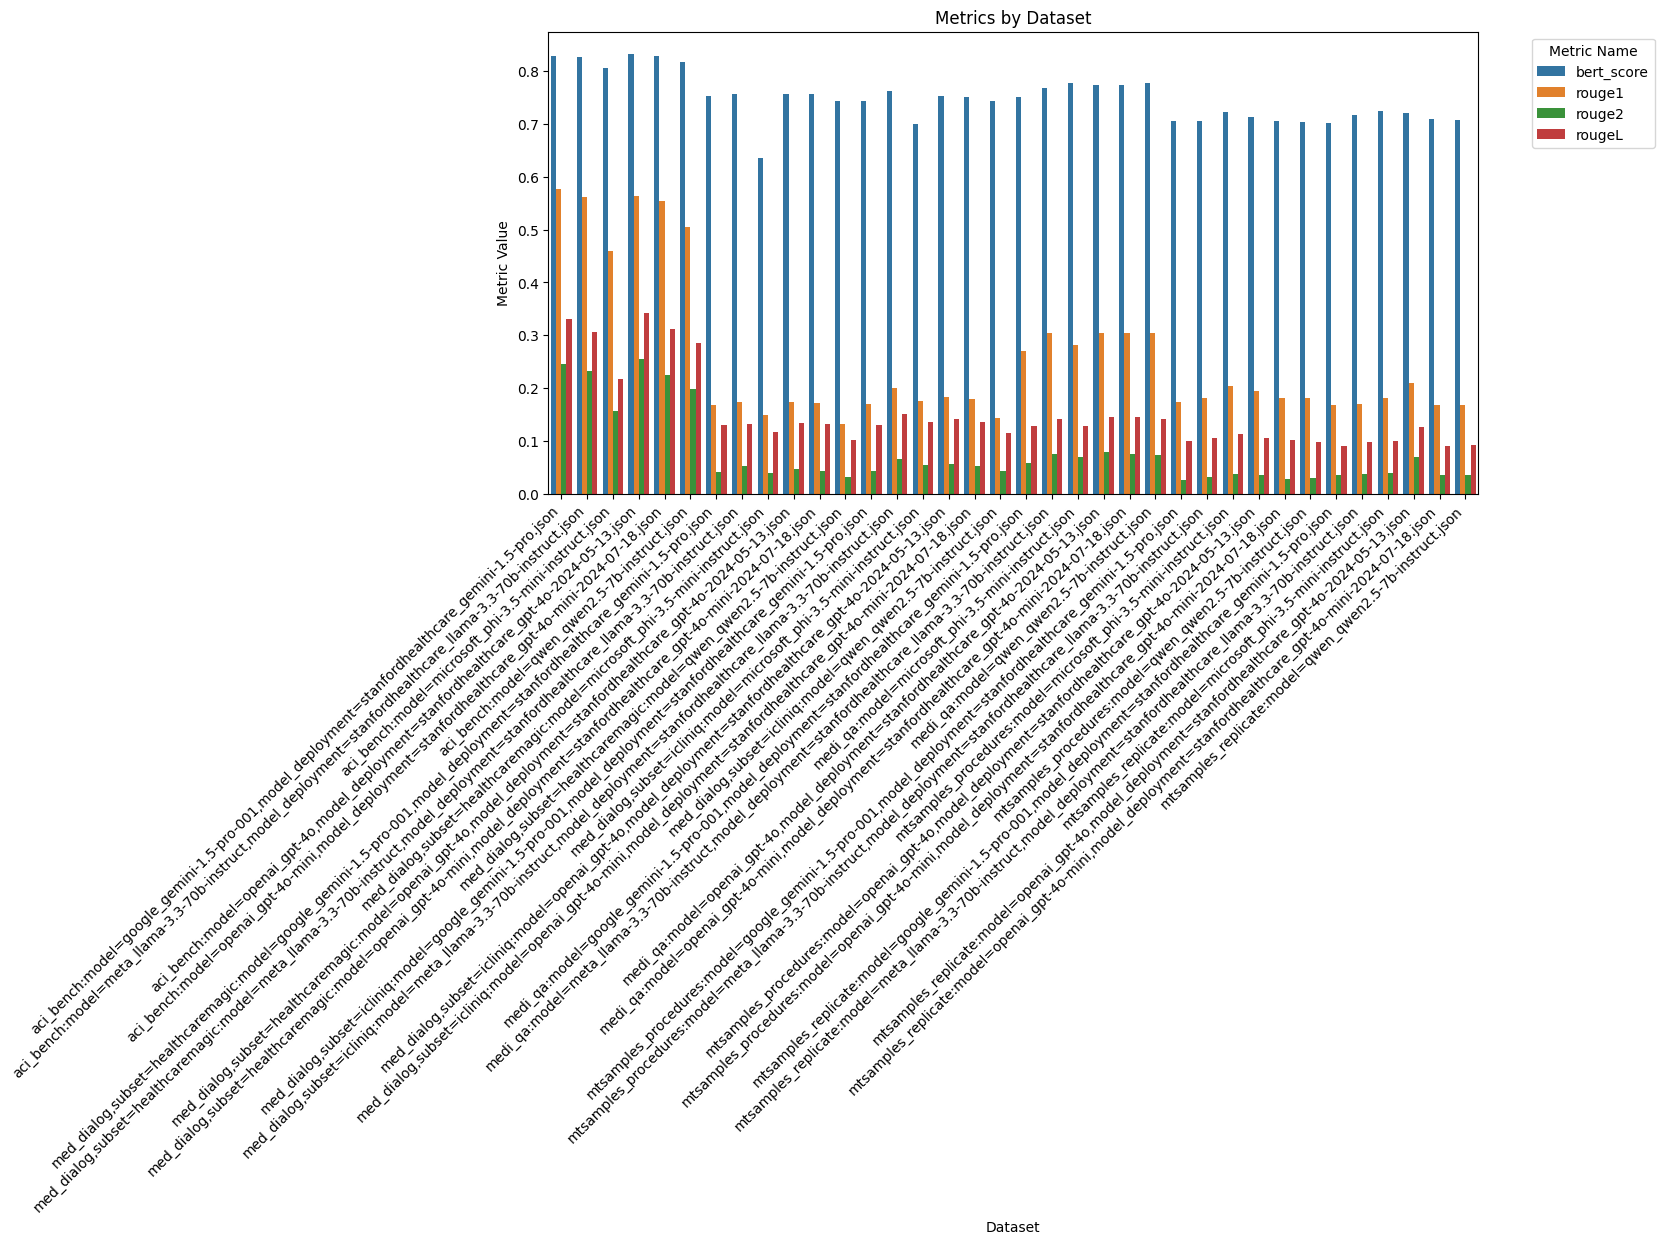

In [9]:
# Group the data by dataset and metric_name
grouped = medhelm_metrics_df.groupby(['id', 'metric_name'])['medhelm_metric_value'].mean().reset_index()

# Create a bar plot for metrics grouped by dataset
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='id', y='medhelm_metric_value', hue='metric_name')

# Customize the plot
plt.title('Metrics by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [10]:
model_runs_ids = medhelm_metrics_df["id"].unique().tolist()

all_medbench_metrics_data = []
for model_run_id in model_runs_ids:
    model_run: ModelRun = model_runs[model_run_id]

    print(f"Calculating MedBench metrics for {model_run_id}...")
    start = time.time()
    metrics_results = calculate_summarization_metrics(model_run)
    end = time.time()

    print(f"Time taken to calculate metrics for {model_run_id}: {end - start:.2f} seconds")

    for metric_name, metric_val in metrics_results["aggregated_metrics"].items():
        all_medbench_metrics_data.append(
            {
                "id": model_run_id,
                "model": model_run.model.name,
                "dataset": model_run.dataset.name,
                "metric_name": metric_name,
                "medbench_metric_value": metric_val,
            }
        )

medbench_metrics_df = pd.DataFrame(all_medbench_metrics_data)

medbench_metrics_df.head()

Calculating MedBench metrics for med_dialog,subset=icliniq:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=icliniq:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json: 275.83 seconds
Calculating MedBench metrics for med_dialog,subset=healthcaremagic:model=microsoft_phi-3.5-mini-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=healthcaremagic:model=microsoft_phi-3.5-mini-instruct.json: 305.04 seconds
Calculating MedBench metrics for aci_bench:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for aci_bench:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json: 152.81 seconds
Calculating MedBench metrics for mtsamples_procedures:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_procedures:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json: 58.33 seconds
Calculating MedBench metrics for mtsamples_procedures:model=microsoft_phi-3.5-mini-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_procedures:model=microsoft_phi-3.5-mini-instruct.json: 57.01 seconds
Calculating MedBench metrics for med_dialog,subset=icliniq:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=icliniq:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json: 234.26 seconds
Calculating MedBench metrics for aci_bench:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for aci_bench:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json: 114.95 seconds
Calculating MedBench metrics for aci_bench:model=qwen_qwen2.5-7b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for aci_bench:model=qwen_qwen2.5-7b-instruct.json: 85.88 seconds
Calculating MedBench metrics for medi_qa:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for medi_qa:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json: 149.21 seconds
Calculating MedBench metrics for mtsamples_replicate:model=qwen_qwen2.5-7b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_replicate:model=qwen_qwen2.5-7b-instruct.json: 78.97 seconds
Calculating MedBench metrics for mtsamples_procedures:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_procedures:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json: 72.06 seconds
Calculating MedBench metrics for mtsamples_replicate:model=microsoft_phi-3.5-mini-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_replicate:model=microsoft_phi-3.5-mini-instruct.json: 54.17 seconds
Calculating MedBench metrics for med_dialog,subset=healthcaremagic:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=healthcaremagic:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json: 256.35 seconds
Calculating MedBench metrics for medi_qa:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for medi_qa:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json: 180.50 seconds
Calculating MedBench metrics for mtsamples_replicate:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_replicate:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json: 80.29 seconds
Calculating MedBench metrics for med_dialog,subset=icliniq:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=icliniq:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json: 248.78 seconds
Calculating MedBench metrics for mtsamples_procedures:model=qwen_qwen2.5-7b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_procedures:model=qwen_qwen2.5-7b-instruct.json: 61.56 seconds
Calculating MedBench metrics for medi_qa:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for medi_qa:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json: 106.44 seconds
Calculating MedBench metrics for med_dialog,subset=healthcaremagic:model=qwen_qwen2.5-7b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=healthcaremagic:model=qwen_qwen2.5-7b-instruct.json: 295.86 seconds
Calculating MedBench metrics for med_dialog,subset=healthcaremagic:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=healthcaremagic:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json: 217.50 seconds
Calculating MedBench metrics for aci_bench:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for aci_bench:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json: 89.16 seconds
Calculating MedBench metrics for med_dialog,subset=healthcaremagic:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=healthcaremagic:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json: 235.12 seconds
Calculating MedBench metrics for mtsamples_procedures:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_procedures:model=openai_gpt-4o-mini,model_deployment=stanfordhealthcare_gpt-4o-mini-2024-07-18.json: 85.24 seconds
Calculating MedBench metrics for aci_bench:model=microsoft_phi-3.5-mini-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for aci_bench:model=microsoft_phi-3.5-mini-instruct.json: 119.36 seconds
Calculating MedBench metrics for mtsamples_replicate:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_replicate:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json: 92.44 seconds
Calculating MedBench metrics for mtsamples_replicate:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_replicate:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json: 102.40 seconds
Calculating MedBench metrics for med_dialog,subset=healthcaremagic:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=healthcaremagic:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json: 228.60 seconds
Calculating MedBench metrics for aci_bench:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for aci_bench:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json: 95.79 seconds
Calculating MedBench metrics for medi_qa:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for medi_qa:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json: 114.64 seconds
Calculating MedBench metrics for med_dialog,subset=icliniq:model=qwen_qwen2.5-7b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=icliniq:model=qwen_qwen2.5-7b-instruct.json: 288.17 seconds
Calculating MedBench metrics for med_dialog,subset=icliniq:model=microsoft_phi-3.5-mini-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=icliniq:model=microsoft_phi-3.5-mini-instruct.json: 249.77 seconds
Calculating MedBench metrics for med_dialog,subset=icliniq:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for med_dialog,subset=icliniq:model=meta_llama-3.3-70b-instruct,model_deployment=stanfordhealthcare_llama-3.3-70b-instruct.json: 276.51 seconds
Calculating MedBench metrics for medi_qa:model=microsoft_phi-3.5-mini-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for medi_qa:model=microsoft_phi-3.5-mini-instruct.json: 150.10 seconds
Calculating MedBench metrics for mtsamples_replicate:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_replicate:model=openai_gpt-4o,model_deployment=stanfordhealthcare_gpt-4o-2024-05-13.json: 71.92 seconds
Calculating MedBench metrics for medi_qa:model=qwen_qwen2.5-7b-instruct.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for medi_qa:model=qwen_qwen2.5-7b-instruct.json: 170.73 seconds
Calculating MedBench metrics for mtsamples_procedures:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lschettini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Time taken to calculate metrics for mtsamples_procedures:model=google_gemini-1.5-pro-001,model_deployment=stanfordhealthcare_gemini-1.5-pro.json: 60.25 seconds


,id,model,dataset,metric_name,medbench_metric_value
0,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,rouge1,0.170336
1,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,rouge2,0.043668
2,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,rougeL,0.130871
3,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,bleu,0.023377
4,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,meteor,0.176351


In [11]:
# Merge medhelm and medbench metrics dataframes
metrics_df = pd.merge(
    medhelm_metrics_df,
    medbench_metrics_df,
    on=["id", "model", "dataset", "metric_name"],
)

# Make sure metrics are floats
metrics_df["medhelm_metric_value"] = metrics_df["medhelm_metric_value"].astype(float)
metrics_df["medbench_metric_value"] = metrics_df["medbench_metric_value"].astype(float)

In [12]:
# Group by metric_name and calculate the correlation for each metric
correlations = (
    metrics_df.groupby("metric_name")
    .apply(lambda group: group["medhelm_metric_value"].corr(group["medbench_metric_value"]))
    .reset_index()
)

# Rename columns for clarity
correlations.columns = ["metric_name", "correlation"]

# Display the correlations
correlations

/tmp/ipykernel_1275223/837788959.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group["medhelm_metric_value"].corr(group["medbench_metric_value"]))


,metric_name,correlation
0,bert_score,0.890876
1,rouge1,1.000000
2,rouge2,1.000000
3,rougeL,1.000000


In [13]:
metrics_df.head()

,id,model,dataset,metric_name,medhelm_metric_value,medbench_metric_value
0,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,bert_score,0.742938,0.460699
1,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,rouge1,0.170336,0.170336
2,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,rouge2,0.043668,0.043668
3,"med_dialog,subset=icliniq:model=google_gemini-...",google/gemini-1.5-pro-001,med_dialog,rougeL,0.130871,0.130871
4,"med_dialog,subset=healthcaremagic:model=micros...",microsoft/phi-3.5-mini-instruct,med_dialog,bert_score,0.636296,0.401780


In [14]:
def rank_models(group, value_target_pairs: list[tuple[str, str]]) -> pd.DataFrame:
    for metric_value_column, target_rank_column in value_target_pairs:
        group[target_rank_column] = group[metric_value_column].rank(ascending=False)
    return group


metrics_df = metrics_df.groupby(["dataset", "metric_name"]).apply(
    lambda group: rank_models(
        group,
        [
            ("medbench_metric_value", "medbench_rank"),
            ("medhelm_metric_value", "medhelm_rank"),
        ],
    ),
    include_groups=True,
)
metrics_df.reset_index(drop=True, inplace=True)

metrics_df.head()

/tmp/ipykernel_1275223/2002142383.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = metrics_df.groupby(["dataset", "metric_name"]).apply(


,id,model,dataset,metric_name,medhelm_metric_value,medbench_metric_value,medbench_rank,medhelm_rank
0,"aci_bench:model=openai_gpt-4o-mini,model_deplo...",openai/gpt-4o-mini,aci_bench,bert_score,0.827962,0.674935,3.0,2.0
1,"aci_bench:model=google_gemini-1.5-pro-001,mode...",google/gemini-1.5-pro-001,aci_bench,bert_score,0.827954,0.677187,2.0,3.0
2,aci_bench:model=qwen_qwen2.5-7b-instruct.json,qwen/qwen2.5-7b-instruct,aci_bench,bert_score,0.817811,0.657751,5.0,5.0
3,"aci_bench:model=openai_gpt-4o,model_deployment...",openai/gpt-4o,aci_bench,bert_score,0.833289,0.682779,1.0,1.0
4,aci_bench:model=microsoft_phi-3.5-mini-instruc...,microsoft/phi-3.5-mini-instruct,aci_bench,bert_score,0.805776,0.634713,6.0,6.0


In [15]:
# calculate accuracy of medbench rank compared to medhelm rank
def calculate_accuracy(group: pd.DataFrame) -> float:
    medbench_rank = group["medbench_rank"].tolist()
    medhelm_rank = group["medhelm_rank"].tolist()
    correct = sum(1 for mb, mh in zip(medbench_rank, medhelm_rank) if mb == mh)
    return correct / len(medbench_rank)

def calculate_accuracy_by(metrics_df: pd.DataFrame, by: list[str]) -> pd.DataFrame:
    accuracy_df = (
        metrics_df.groupby(by)
        .apply(calculate_accuracy)
        .reset_index()
    )
    accuracy_df.columns = by + ["accuracy"]
    return accuracy_df


In [16]:
accuracy_df = calculate_accuracy_by(metrics_df, by=["dataset", "metric_name"])
accuracy_df

/tmp/ipykernel_1275223/75890108.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_accuracy)


,dataset,metric_name,accuracy
0,aci_bench,bert_score,0.666667
1,aci_bench,rouge1,1.000000
2,aci_bench,rouge2,1.000000
3,aci_bench,rougeL,1.000000
4,med_dialog,bert_score,0.500000
5,med_dialog,rouge1,1.000000
6,med_dialog,rouge2,1.000000
7,med_dialog,rougeL,1.000000
8,medi_qa,bert_score,0.333333
9,medi_qa,rouge1,1.000000


In [17]:
calculate_accuracy(metrics_df[metrics_df["metric_name"] != "bert_score"])

1.0

In [18]:
metrics_df[metrics_df["dataset"] == "mtsamples_replicate"].sort_values(
    by=["metric_name", "medbench_rank"],
    ascending=[True, True],
)

,id,model,dataset,metric_name,medhelm_metric_value,medbench_metric_value,medbench_rank,medhelm_rank
125,"mtsamples_replicate:model=openai_gpt-4o,model_...",openai/gpt-4o,mtsamples_replicate,bert_score,0.721617,0.502025,1.0,2.0
121,mtsamples_replicate:model=microsoft_phi-3.5-mi...,microsoft/phi-3.5-mini-instruct,mtsamples_replicate,bert_score,0.724742,0.494696,2.0,1.0
124,mtsamples_replicate:model=meta_llama-3.3-70b-i...,meta/llama-3.3-70b-instruct,mtsamples_replicate,bert_score,0.717061,0.489308,3.0,3.0
122,"mtsamples_replicate:model=openai_gpt-4o-mini,m...",openai/gpt-4o-mini,mtsamples_replicate,bert_score,0.709019,0.481266,4.0,4.0
120,mtsamples_replicate:model=qwen_qwen2.5-7b-inst...,qwen/qwen2.5-7b-instruct,mtsamples_replicate,bert_score,0.708272,0.478194,5.0,5.0
123,mtsamples_replicate:model=google_gemini-1.5-pr...,google/gemini-1.5-pro-001,mtsamples_replicate,bert_score,0.701816,0.462130,6.0,6.0
131,"mtsamples_replicate:model=openai_gpt-4o,model_...",openai/gpt-4o,mtsamples_replicate,rouge1,0.209319,0.209319,1.0,1.0
127,mtsamples_replicate:model=microsoft_phi-3.5-mi...,microsoft/phi-3.5-mini-instruct,mtsamples_replicate,rouge1,0.180426,0.180426,2.0,2.0
130,mtsamples_replicate:model=meta_llama-3.3-70b-i...,meta/llama-3.3-70b-instruct,mtsamples_replicate,rouge1,0.169996,0.169996,3.0,3.0
126,mtsamples_replicate:model=qwen_qwen2.5-7b-inst...,qwen/qwen2.5-7b-instruct,mtsamples_replicate,rouge1,0.168780,0.168780,4.0,4.0
